# Training a classifier

### Data
Generally, when we have to deal with image, text, audio or video data, we can use standard python packages that load data into a numpy array. Then we can convert this array into a __torch.*Tensor__.

* For images, packages such as Pillow, OpenCV are useful
* For audio, packages such as scipy and librosa
* For text, either raw Python or Cython based loading, or NLTK and SpaCy are useful

Specifically for vision, we have created a package called __torchvision__, that has data loaders for common datasets such as Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz., __torchvision.datasets__ and __torch.utils.data.DataLoader__.

For this tutorial, we will use the __CIFAR10__ dataset. It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

### Training an image classifier
1. Load and normalizing the CIFAR10 training and test datasets using __torchvision__
1. Define a Convolutional Neural Network
1. Define a loss function
1. Train the network on the training data
1. Test the network on the test data

#### 1. Loading and normalizing CIFAR10

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Show some of the training images

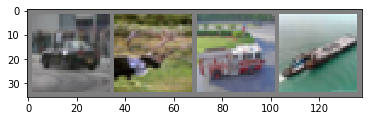

  car  deer truck  ship


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

#### 2. Define a Convolutional Neural Network

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


#### 3. Define a Loss function and optimizer
Let's use a Classification Cross-Entropy loss and SGD with momentum.

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9)

#### 4. Train the network
We simply have to loop over our data iterator, and feed the inputs to the network and optimize.

In [6]:
for epoch in range(10): # loop over the dataset multiple times
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999: # print every 2000 mini-batches
            print('[%d %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
            
print('Finished Training')

[1  2000] loss: 2.236
[1  4000] loss: 1.872
[1  6000] loss: 1.709
[1  8000] loss: 1.610
[1 10000] loss: 1.559
[1 12000] loss: 1.488
[2  2000] loss: 1.421
[2  4000] loss: 1.384
[2  6000] loss: 1.360
[2  8000] loss: 1.337
[2 10000] loss: 1.304
[2 12000] loss: 1.271
[3  2000] loss: 1.197
[3  4000] loss: 1.219
[3  6000] loss: 1.182
[3  8000] loss: 1.184
[3 10000] loss: 1.165
[3 12000] loss: 1.183
[4  2000] loss: 1.084
[4  4000] loss: 1.104
[4  6000] loss: 1.085
[4  8000] loss: 1.111
[4 10000] loss: 1.073
[4 12000] loss: 1.089
[5  2000] loss: 0.995
[5  4000] loss: 1.019
[5  6000] loss: 1.026
[5  8000] loss: 1.010
[5 10000] loss: 1.016
[5 12000] loss: 1.028
[6  2000] loss: 0.920
[6  4000] loss: 0.947
[6  6000] loss: 0.965
[6  8000] loss: 0.981
[6 10000] loss: 0.980
[6 12000] loss: 0.991
[7  2000] loss: 0.872
[7  4000] loss: 0.925
[7  6000] loss: 0.933
[7  8000] loss: 0.911
[7 10000] loss: 0.956
[7 12000] loss: 0.921
[8  2000] loss: 0.844
[8  4000] loss: 0.859
[8  6000] loss: 0.876
[8  8000] 

Let's quickly save the trained model

In [7]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

#### 5. Test the network on the test data
We have trained the network for 2 passes over the training dataset. But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.

First, let's display an image from the test set to get familiar.

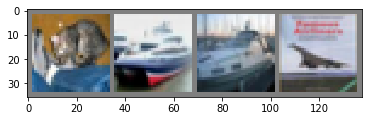

GroundTruth:    cat  ship  ship plane


In [8]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Next, let’s load back in our saved model (note: saving and re-loading the model wasn’t necessary here, we only did it to illustrate how to do so).

In [9]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Now let us see what the neural network thinks these examples above are.

In [10]:
outputs = net(images)

The outputs are energies for the 10 classes. The higher the energy for a class, the more the network thinks that the image is of the particular class. So, let’s get the index of the highest energy.

In [11]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:    cat  ship  ship plane


Let us look at how the network performs on the whole dataset.

In [12]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 63 %


That looks way better than chance, which is 10% accuracy (randomly picking a class out of 10 classes). Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did not perform well.

In [13]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            
for i in range(10):
    print('Accuracy of %5s : %2d %%' %
          (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 64 %
Accuracy of   car : 76 %
Accuracy of  bird : 57 %
Accuracy of   cat : 45 %
Accuracy of  deer : 61 %
Accuracy of   dog : 49 %
Accuracy of  frog : 75 %
Accuracy of horse : 54 %
Accuracy of  ship : 79 %
Accuracy of truck : 66 %


### Training on GPU
Define our device as the first visible cuda device if we have CUDA available

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cpu
